# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [1]:
from typing import Optional, Union


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.datasets import mnist
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.utils import to_categorical

2023-07-27 11:35:21.749080: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-27 11:35:21.750682: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-27 11:35:21.783768: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-27 11:35:21.784449: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-27 11:35:22.457487: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

#### O/S/E

In [2]:
num_classes = 10  # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784  # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001  # скорость обучения нейронной сети
training_steps = 3000  # максимальное число эпох
batch_size = 256  # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100  # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128  # количество нейронов 1-го слоя
n_hidden_2 = 256  # количество нейронов 2-го слоя

buffer_size = 5000  # This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements.

- https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch

In [3]:
# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типу float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

In [4]:
# Перемешаем тренировочные данные (split to batches & ...)
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(buffer_size).batch(batch_size).prefetch(1)

In [5]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

In [6]:
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [7]:
y_train.shape, y_test.shape

((60000,), (10000,))

#### M

- https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid
- https://www.tensorflow.org/api_docs/python/tf/random/normal
- https://stackoverflow.com/questions/66968102/python-type-hint-can-tensorflow-data-type-be-used
- https://www.tensorflow.org/api_docs/python/tf/nn/relu
- https://www.tensorflow.org/api_docs/python/tf/nn/softmax

In [8]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features: int, out_features: int, name: Optional[str]=None) -> None:
        super().__init__(name=name)
        self.w = tf.Variable(
                             tf.random.normal([in_features, out_features]), 
                             name='w'
                             )
        self.b = tf.Variable(tf.random.normal([out_features]), name='b')

    def __call__(self, x: tf.float32) -> tf.float32:
        y = tf.matmul(x, self.w) + self.b
        
        return sigmoid(y) if self.name == 'sigmoid' else tf.nn.softmax(y) if self.name == 'softmax' else y


class NN(tf.Module):
  def __init__(self, name: Optional[str]=None) -> None:
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1, name='sigmoid')

    # Второй слой, состоящий из 256 нейронов
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2, name='sigmoid')

    # Выходной слой
    self.layer_out = DenseLayer(in_features=n_hidden_2, out_features=num_classes, name='softmax')

  def __call__(self, x: tf.float32) -> tf.float32:
    x = self.layer_1(x)
    x = self.layer_2(x)

    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax. 
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью 
    # принадлежности входного объекта к одному из 10 классов

    x = self.layer_out(x)
    
    return x

- https://www.tensorflow.org/api_docs/python/tf/one_hot
- https://www.tensorflow.org/api_docs/python/tf/clip_by_value
- https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
- https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D1%85%D1%80%D0%B5%D1%81%D0%BD%D0%B0_%D0%B5%D0%BD%D1%82%D1%80%D0%BE%D0%BF%D1%96%D1%8F
- https://www.tensorflow.org/api_docs/python/tf/compat/v1/metrics/accuracy
- https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy

- https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy
- https://www.tensorflow.org/api_docs/python/tf/keras/metrics/categorical_crossentropy

In [9]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [10]:
y_true = tf.one_hot(y_train, depth=num_classes)

In [11]:
y_true

<tf.Tensor: shape=(60000, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)>

In [12]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию (num_classes > 2)
def cross_entropy(y_pred: tf.float32, y_true: np.array) -> tf.float32:
    # Encode label to a one hot vector.
    # y_true = to_categorical(y_true, num_classes=num_classes)
    y_true = tf.one_hot(y_true, depth=num_classes)
    
    # Clip prediction values to avoid log(0) error. (acording to min and max value)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии (reduce_mean - Computes the mean of elements across dimensions of a tensor.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))


# В качестве метрики качества используем точность
def accuracy(y_pred: tf.float32, y_true: np.array) -> float:
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = np.where(y_pred==[[i] for i in np.amax(y_pred,axis=1)], 1, 0)
    m = Accuracy()
    m.update_state(y_true, y_pred)

    return m.result().numpy()

- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/SGD
- https://www.tensorflow.org/api_docs/python/tf/GradientTape

In [13]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y, learning_rate):
    # Для подгонки весов сети будем использовать стохастический градиентный спуск:
    optimizer = tf.optimizers.legacy.SGD(learning_rate)  # .Adam

    # Активация автоматического дифференцирования
    with tf.GradientTape() as g:
        pred = nn(input_x)  #  neural_net(input_x)
        loss = cross_entropy(pred, output_y)

        # Создадим оптимизируемых список параметров
        params = [nn.layer_1.trainable_variables, nn.layer_2.trainable_variables, nn.layer_out.trainable_variables]

        # Вычислим по ним значение градиента
        grads = g.gradient(loss, params)

        # Модифицируем параметры
        optimizer.apply_gradients(zip(grads[0], nn.layer_1.trainable_variables))
        optimizer.apply_gradients(zip(grads[1], nn.layer_2.trainable_variables))
        optimizer.apply_gradients(zip(grads[2], nn.layer_out.trainable_variables))


In [14]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором 
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(buffer_size)):  # train_data.take(batch_size)
    # Обновляем веса нейронной сети
    train(neural_net, batch_x, batch_y, learning_rate=learning_rate)
    pred = neural_net(batch_x)
    current_loss = cross_entropy(pred, batch_y)
    
    if step % display_step == 0:
        loss_history.append(current_loss)
        accuracy_history.append(accuracy(pred, batch_y))

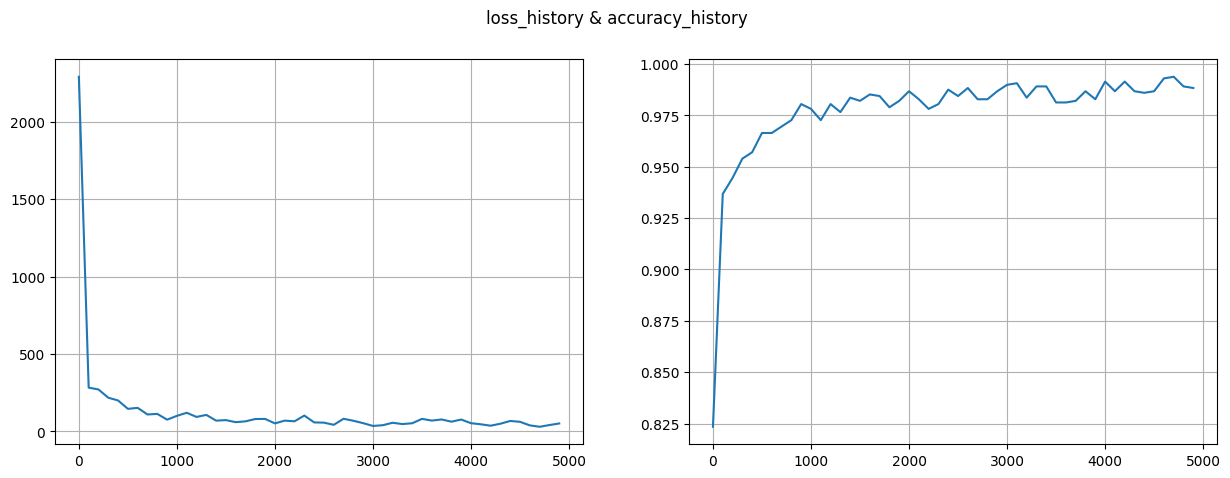

In [15]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться
def draw_2simple_2d(x1: np.array, y1: np.array, x2: np.array, y2: np.array, suptitle: str) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(x1, y1)
    axs[0].grid()
    axs[1].plot(x1, y2)
    fig.suptitle(suptitle)
    axs[1].grid()


x = np.array([point * display_step for point in range(len(loss_history))])

draw_2simple_2d(x, loss_history, x, accuracy_history, suptitle='loss_history & accuracy_history')

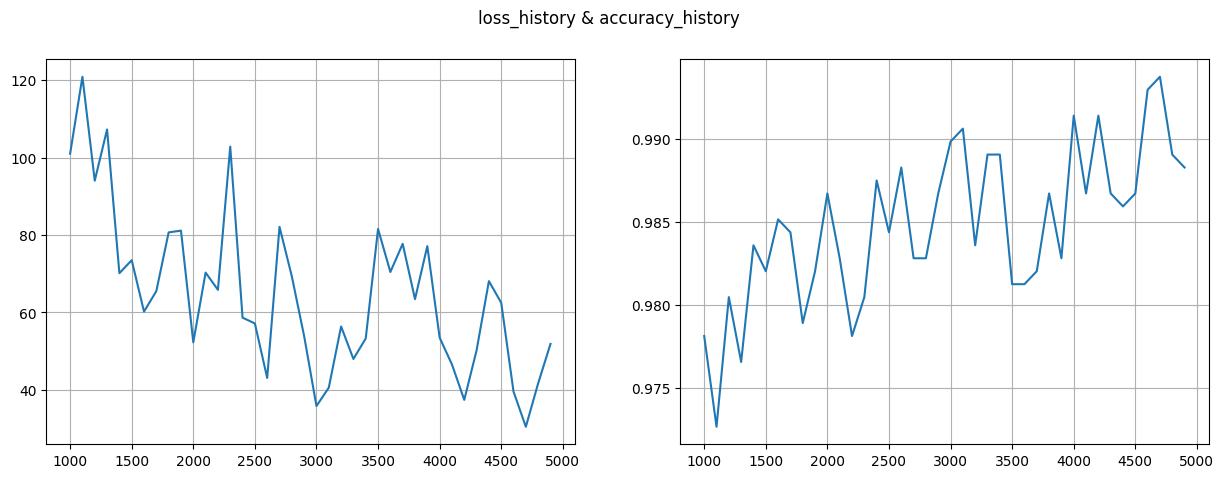

In [16]:
draw_2simple_2d(x[10:], loss_history[10:], x[10:], accuracy_history[10:], suptitle='loss_history & accuracy_history')

In [17]:
# Вычислите точность обученной нейросети
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.shuffle(buffer_size).batch(1).prefetch(1)

def test_NN(nn, test_data) -> float:
    accuracy_history = []
    for x_t, y_t in test_data.take(1):
        pred = nn(x_t)
        accuracy_history.append(accuracy(pred, y_t))

    return np.mean(accuracy_history)

In [18]:
accuracy_NN = test_NN(neural_net, test_data)
accuracy_NN 

1.0

In [77]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5 
# случайных изображений и передайте их в нейронню сеть.

# 5 from test_
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.shuffle(buffer_size).batch(5).prefetch(1)
# and 5 from train
test_data5 = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_data5 = test_data5.shuffle(buffer_size).batch(5).prefetch(1)

accuracy_NN_test1 = test_NN(neural_net, test_data)
accuracy_NN_test2 = test_NN(neural_net, test_data5)
accuracy_NN_test = np.mean([accuracy_NN_test1, accuracy_NN_test2])
accuracy_NN_test  # mean from train and test

0.96000004

In [ ]:
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

- https://stackoverflow.com/questions/46923244/how-to-create-image-from-a-list-of-pixel-values-in-python3
- https://pillow.readthedocs.io/en/latest/reference/Image.html
- https://numpy.org/doc/stable/reference/generated/numpy.argmax.html
- https://stackoverflow.com/questions/19471814/display-multiple-images-in-one-ipython-notebook-cell

In [60]:
from PIL import Image

In [68]:
def print_NN_results(nn, test_data) -> None:
    for x_t, y_t in test_data:
        for sample in range(test_data.get_single_element()[1].numpy().shape[0]):
            img = Image.fromarray((x_t.numpy()[sample].reshape(28, 28) * 255).astype(np.uint8))
            display(img)  # uses buildin display
            pred = nn(x_t).numpy()[sample]
            print(f'True value: {y_t[sample]} => model response: {np.argmax(pred)}\n\n')


In [69]:
print_NN_results(neural_net, test_data.take(1))

True value: 3 => model response: 3




True value: 2 => model response: 2




True value: 6 => model response: 6




True value: 7 => model response: 7




True value: 3 => model response: 3




In [84]:
print_NN_results(neural_net, test_data5.take(1))

True value: 7 => model response: 7




True value: 8 => model response: 8




True value: 1 => model response: 1




True value: 0 => model response: 0




True value: 7 => model response: 7




##### Альтернативне відображення результатів

In [87]:
from matplotlib.pyplot import imshow
from IPython.display import display  # another display function instead of the built-in one


def altprint_NN_results(nn, test_data) -> None:
    for x_t, y_t in test_data:
        for sample in range(test_data.get_single_element()[1].numpy().shape[0]):
            plt.imshow((x_t.numpy()[sample].reshape(28, 28) * 255).astype(np.uint8))
            pred = nn(x_t).numpy()[sample]
            plt.title(f'True value: {y_t[sample]} => model response: {np.argmax(pred)}')
            plt.show()


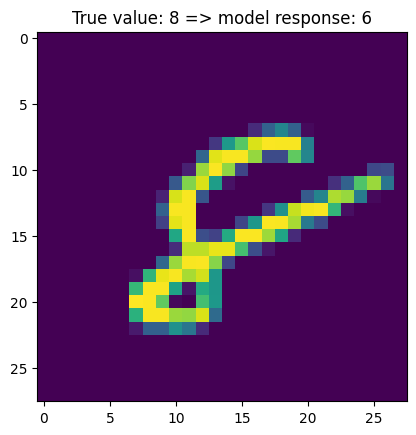

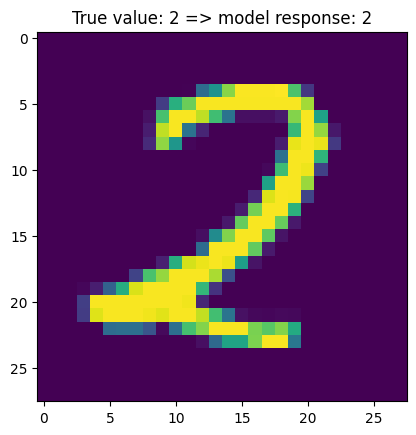

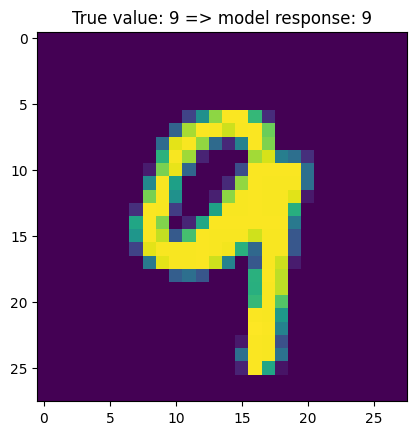

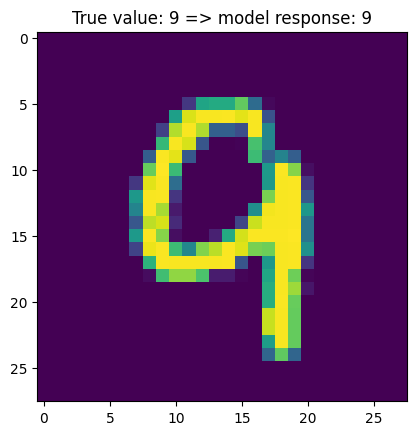

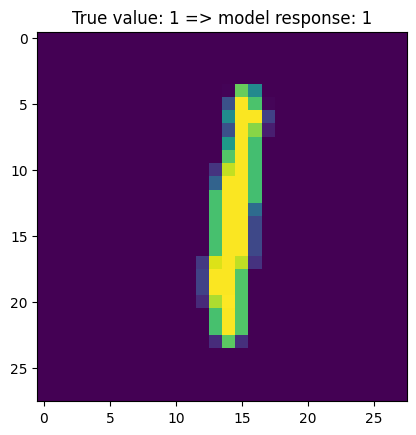

In [88]:
altprint_NN_results(neural_net, test_data.take(1))

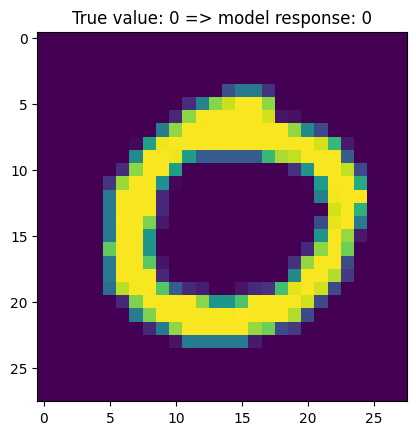

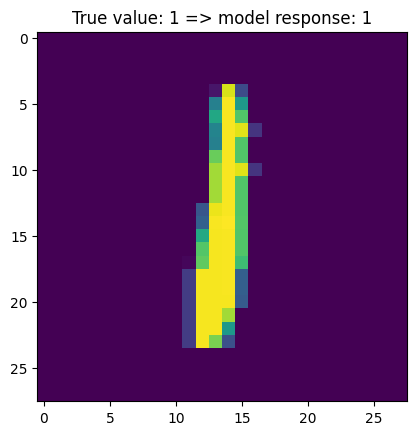

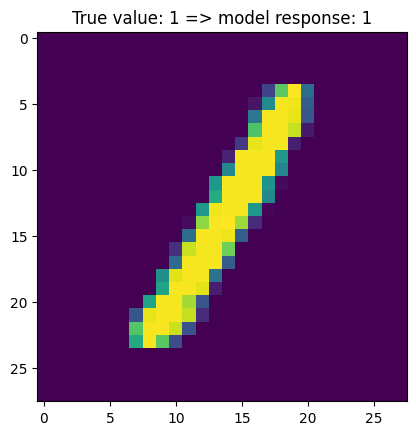

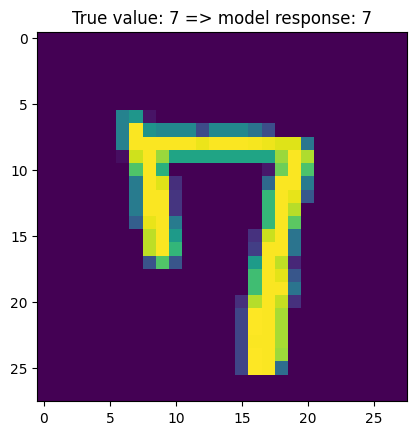

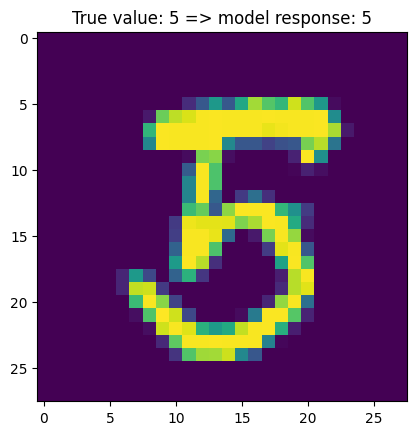

In [89]:
altprint_NN_results(neural_net, test_data5.take(1))

##### Висновок: На тестовій вибірці модель показує відмінний результат (практично 100%), на тренувальній - більше 90% точність. В середньому можна сказати, що точність моделі складає 90+%. Звичайно при багаторазовому запуску (рандомному перемішуванні, у тренувальній вибірці особливо, та новим рандомним обиранням початковим коефіцієнтів в моделі) можна помітити коливання результатів приблизно в межах декількох % (95±5%). Тобто модель майже не помиляється.